# Opnieuw uitvoeren van paar maand terug
Dit keer eerst maar de testbestanden aanmaken

In [1]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from util import util
from util import WavFileParts
from util.logUtil import LOG, LOG_HEADER
from util.confusionMatrix import ConfusionMatrix


Using TensorFlow backend.


### globale settings

In [2]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir
recordingDir = osDir + '/localizationRecordings'

if osDir == winDir:
    storageFolder = 'E:/SAA_DATA/storedData/'
else:
    storageFolder = '/Users/etto/Desktop/storedData/'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

orgsG428 = ['G428_0.0_1.4','G428_2.1_2.4']
orgsG527 = ['G527_0.5_1.4','G527_1.2_5.8']
orgsStudio = ['Studio_2.0_4.2','Studio_3.0_2.0']

chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [3]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allSpectros, allClasses, storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    df = pd.DataFrame(allSpectros)
    df.to_hdf(path_or_buf=filename, key='spectros_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    specDf = pd.read_hdf(path_or_buf=filename, key='spectros_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return specDf.values, classesDf.values
    

### functies tbv trainen

In [4]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

def getFilesPerCatFromMultipleDirs(srcDirs, srcDirsBase=''):
    filesPerCat = {}
    for dirName in srcDirs:
        srcDir = srcDirsBase + '/' + dirName
        fpcNw = getFilesPerCategory(srcDir)
        if not filesPerCat:
            filesPerCat = fpcNw
        else:
            for key in filesPerCat:
                filesPerCat[key] += fpcNw[key]
    return filesPerCat
        

In [5]:
# Maakt een dictionary aan; per categorie de spectrogrammen
def getSpectrosFromFilesPerCategory(filesPerCategory, NFFT):
    spectros = {}
    for clz in classes:
        spectros[clz] = []
        for filename in filesPerCategory[clz]:
            fs, signal = wv.read(filename)
            freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)
            spectros[clz].append(spectrogram.T)
    return spectros

In [6]:
def getClassLengths(spectrosPerCat):
    clzLengths = {}
    for clz in classes:
        clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectrosPerCat[clz]])
    return clzLengths

In [7]:
# verwacht invoer van getSpectrosFromFilesPerCategory
# levert traindata op (X_train en Y_train)
def createTrainDataFromSpectros(spectrosPerCat, clzLengths):
    X_train = np.concatenate(spectrosPerCat[classes[0]], axis=0)
    for i in range(1, len(classes)):
        nwSpectros = np.concatenate(spectrosPerCat[classes[i]], axis=0)
        X_train = np.concatenate((X_train,nwSpectros), axis=0)
    
    # one-hot encoding voor Y_train
    nrFiles = clzLengths[classes[0]]
    Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

    nrFiles = clzLengths[classes[1]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.ones(nrFiles), np.zeros(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

    nrFiles = clzLengths[classes[2]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.zeros(nrFiles), np.ones(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
    
    return X_train, Y_train

### deep learning model

In [8]:
def create_model(layersizes, NFFT):
    # create model
    model = Sequential()
    model.add(Dense(layersizes[0], input_dim=(int(NFFT/2+1)), activation='relu'))
    for lsize in layersizes[1:]:
        model.add(Dense(lsize, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs):
    modelFilename = modelFilePath + baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    modelFilename += '.hd5'
    return modelFilename

In [10]:
def getModelName(baseModelFilename, layers, nrEpochs):
    modelFilename = baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    return modelFilename

In [11]:
def train_model(X_train, Y_train, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()

In [12]:
def train_and_evaluate_model(X_train, Y_train, realTrainClasses, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()
    evaluate_model(X_train, realTrainClasses,layers, nrEpochs, modelFilePath, baseModelFilename)

In [13]:
def evaluate_model(X_test, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = load_model(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))

    # predicted classes
    predictions = soundModel.predict(X_test)
    predClasses = predictions.argmax(axis=1)

    matrix = ConfusionMatrix(classes)
    for vals in zip(realClasses, predClasses):
        matrix.add(int(vals[0]), int(vals[1]), 1)
    LOG(matrix.toString(),True)
    LOG('', True)
    LOG(matrix.toF1String(), True)
    return matrix

In [14]:
def train_and_evaluate_per_epoch(X_train, Y_train, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    for epNr in range(1, nrEpochs+1):
        LOG('\n*****************\n* Epoch nr {}\n*****************\n'.format(epNr), True)
        soundModel.fit(X_train,Y_train, epochs=1, shuffle=True, verbose=1, batch_size=batch_size)
        soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, epNr))
        evaluate_model(X_train, realClasses, layers, epNr, modelFilePath, baseModelFilename)

### functies tbv testen

In [15]:
def createAndStoreTestData(wavFileParts, baseDir, fileDate, micNr, storeFilename, NFFT, keyName):
    allSpectros = np.array([])
    allClasses = np.array([])

    for wfPt in wavFileParts: #type: WavFilePart
        if not 'Gunshot' in wfPt.getSoundType():
            filename = baseDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wfPt.fileNr, micNr)
            fs, signal = wv.read(filename)

            classNr = classes.index(wfPt.getSoundType().lower())
            for soundChunk in wfPt.getSoundChunks(micNr):
                startFrame = int(soundChunk[0] * fs)
                endFrame = int(soundChunk[1] * fs)

                sigChunk = signal[startFrame: endFrame]
                freq_array, segment_times, spectrogram = sig.spectrogram(x=sigChunk, fs=fs, nfft=NFFT, noverlap=0)
                if len(allSpectros) == 0:
                    allSpectros = spectrogram.T
                else:
                    allSpectros = np.append(allSpectros, spectrogram.T, axis=0)
                allClasses = np.append(allClasses, classNr * np.ones(len(segment_times)))       
    storeTestData(allSpectros, allClasses, storeFilename, NFFT, keyName)


In [16]:
def getTrainDataFromFolders(orgWavDirs, NFFT):
    fpc = getFilesPerCatFromMultipleDirs(orgWavDirs, baseSrcDir)
    spcs = getSpectrosFromFilesPerCategory(fpc, NFFT)
    clzLengths = getClassLengths(spcs)
    X_train, Y_train = createTrainDataFromSpectros(spcs, clzLengths)
    # real train classes
    realTrainClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                                  np.ones(clzLengths[classes[1]]), 
                                  2*np.ones(clzLengths[classes[2]])))
    return X_train, Y_train, realTrainClasses


In [17]:
def testModellen(modelFilePath, layerss, NFFT, micNr, testFileNames, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    for layers in layerss:
        for nrEpochs in nrsEpochs:
            overallMatrix = ConfusionMatrix(classes)
            for testFileName in testFileNames:
                testSpecs, testClasses = retrieveTestData(testFileName, NFFT, keyname)

                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + testFileName,
                           True)
                matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
                overallMatrix.addMatrix(matrix.normalizedCopy())
            
            if showOverall:
                overallMatrix = overallMatrix.normalizedCopy()
                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + 'testData_Overall',
                           True)
                LOG(overallMatrix.toString(),True)
                LOG('', True)
                LOG(overallMatrix.toF1String(), True)

In [18]:
def testModel(modelFilePath, layers, micNr, testFileNames, nrEpochs, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    overallMatrix = ConfusionMatrix(classes)
    for testFileName in testFileNames:
        testSpecs, testClasses = retrieveTestData(testFileName, keyname)

        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + testFileName,
                   True)
        matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
        overallMatrix.addMatrix(matrix.normalizedCopy())

    if showOverall:
        overallMatrix = overallMatrix.normalizedCopy()
        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + 'testData_Overall',
                   True)
        LOG(overallMatrix.toString(),True)
        LOG('', True)
        LOG(overallMatrix.toF1String(), True)

### trainen van model obv: alles G428, G527 en Studio

In [19]:
# Train voor alle lagen
baseModelFilename = '20181215_NFFT2048'
NFFT = 2048
modelFilePath = storageFolder
logPrefix = 'Alle orgs'
orgWavDirs = orgsG428 + orgsG527 + orgsStudio


In [20]:
X_train, Y_train, realTrainClasses = getTrainDataFromFolders(orgWavDirs, NFFT)

In [21]:
layersList = [[100, 20], [400, 250, 100, 20], [400, 300, 200, 100, 50, 20, 10], 
              [450, 400, 350, 300, 250, 200, 150, 100, 50, 21]]
nrEpochs = 3
nrsEpochs = range(1, nrEpochs + 1)
#nrsEpochs = [nrEpochs]
bSize = 128

In [22]:
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_per_epoch(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename, NFFT,
                                batch_size=bSize)

####################################
#
# Alle orgs, lagen: [100, 20]
#
####################################


*****************
* Epoch nr 1
*****************

Epoch 1/1
1108305/1108305 [==============================] - 32s 29us/step - loss: 0.2107 - acc: 0.9214
                   m       v       e |  sens   acc
music         339770   25832     934 |  0.93  0.97
voice           8621  350374    7728 |  0.96  0.95
environment     1341   14688  359017 |  0.96  0.98
--------------------------------------
prec            0.97    0.90    0.98

F1 overall: 0.95
F1 music: 0.95
F1 voice: 0.92
F1 environment: 0.97


*****************
* Epoch nr 2
*****************

Epoch 1/1
1108305/1108305 [==============================] - 31s 28us/step - loss: 0.1278 - acc: 0.9525
                   m       v       e |  sens   acc
music         344014   21912     610 |  0.94  0.97
voice           6915  353915    5893 |  0.97  0.96
environment      979   12401  361666 |  0.96  0.98
---------------------------

In [23]:
# Test alle modellen
testModellen(modelFilePath=storageFolder, 
             layerss=layersList, 
             NFFT=NFFT,
             micNr=4, 
             testFileNames=['testData_G428', 'testData_G527', 'testData_Studio'], 
             showOverall=True)                

####################################
#
# 20181215_NFFT2048_100_20ep1
# mic4
# testData_G428
#
####################################

                   m       v       e |  sens   acc
music          19903     719      17 |  0.96  0.97
voice            714   13488     234 |  0.93  0.96
environment       71      43   13111 |  0.99  0.99
--------------------------------------
prec            0.96    0.95    0.98

F1 overall: 0.96
F1 music: 0.96
F1 voice: 0.94
F1 environment: 0.99

####################################
#
# 20181215_NFFT2048_100_20ep1
# mic4
# testData_G527
#
####################################

                   m       v       e |  sens   acc
music           8791     125       1 |  0.99  0.98
voice            150    2713       3 |  0.95  0.98
environment       12       2    2477 |  0.99  1.00
--------------------------------------
prec            0.98    0.96    1.00

F1 overall: 0.98
F1 music: 0.98
F1 voice: 0.95
F1 environment: 1.00

####################################

                   m       v       e |  sens   acc
music           8850      60       7 |  0.99  0.98
voice            202    2664       0 |  0.93  0.98
environment        6       0    2485 |  1.00  1.00
--------------------------------------
prec            0.98    0.98    1.00

F1 overall: 0.98
F1 music: 0.98
F1 voice: 0.95
F1 environment: 1.00

####################################
#
# 20181215_NFFT2048_400_250_100_20ep2
# mic4
# testData_Studio
#
####################################

                   m       v       e |  sens   acc
music          57552    5170     873 |  0.90  0.95
voice           1320   35925     659 |  0.95  0.95
environment       69     360   41908 |  0.99  0.99
--------------------------------------
prec            0.98    0.87    0.96

F1 overall: 0.94
F1 music: 0.94
F1 voice: 0.91
F1 environment: 0.98

####################################
#
# 20181215_NFFT2048_400_250_100_20ep2
# mic4
# testData_Overall
#
####################################

               

####################################
#
# 20181215_NFFT2048_400_300_200_100_50_20_10ep3
# mic4
# testData_Studio
#
####################################

                   m       v       e |  sens   acc
music          58419    4709     467 |  0.92  0.96
voice            870   36479     555 |  0.96  0.96
environment       59     331   41947 |  0.99  0.99
--------------------------------------
prec            0.98    0.88    0.98

F1 overall: 0.95
F1 music: 0.95
F1 voice: 0.92
F1 environment: 0.98

####################################
#
# 20181215_NFFT2048_400_300_200_100_50_20_10ep3
# mic4
# testData_Overall
#
####################################

                   m       v       e |  sens   acc
music           0.96    0.03    0.00 |  0.96  0.97
voice           0.05    0.95    0.01 |  0.95  0.97
environment     0.00    0.00    0.99 |  0.99  0.99
--------------------------------------
prec            0.95    0.96    0.99

F1 overall: 0.97
F1 music: 0.96
F1 voice: 0.95
F1 environment: 0

In [25]:
from parseExperimentResults import parseRedoExperiment

creating plots in plots/20181215_NFFT2048/


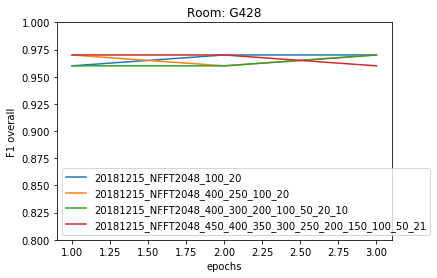

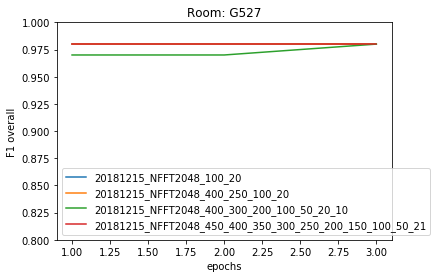

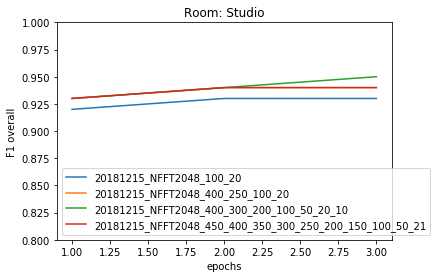

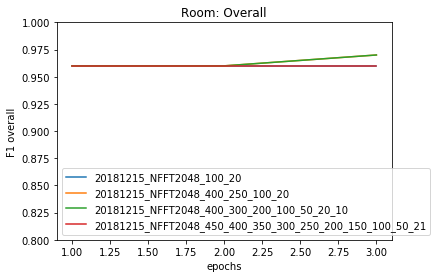

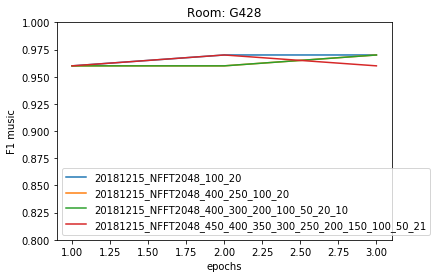

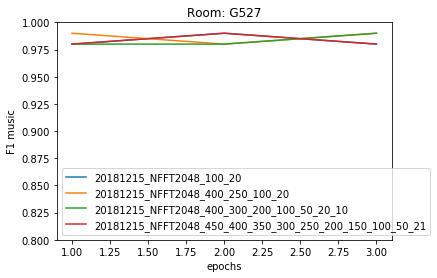

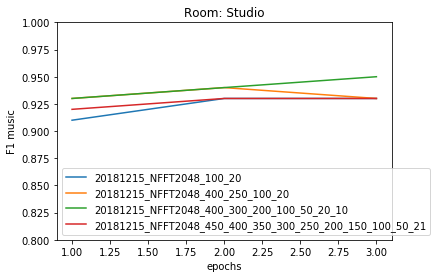

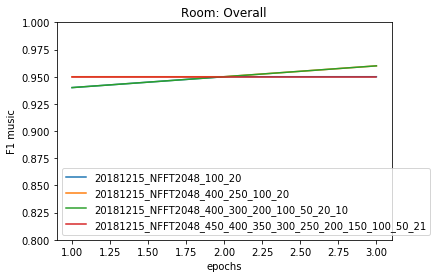

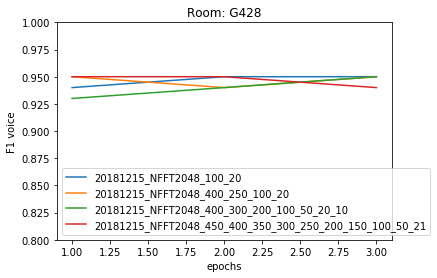

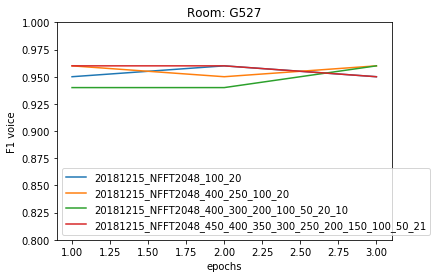

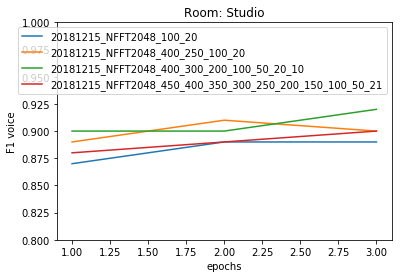

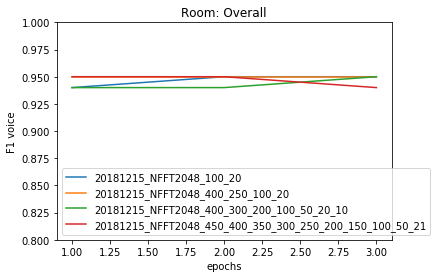

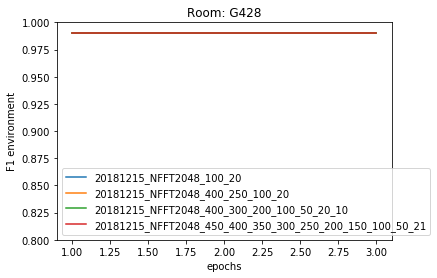

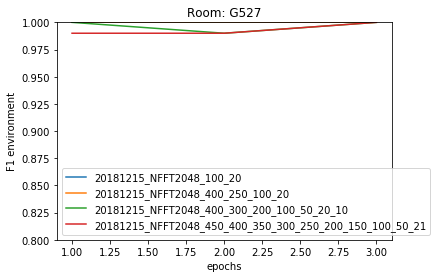

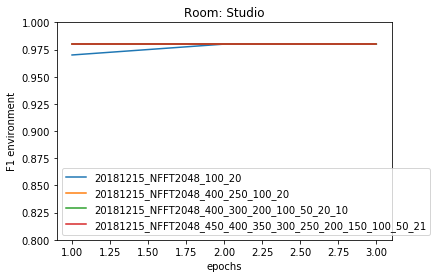

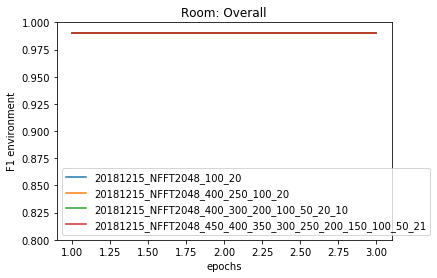

In [26]:
experimentId='20181215_NFFT2048'
filePattern='20181215_NFFT2048'
parseRedoExperiment(experimentId, filePattern)